# Importing Libraries

In [1]:
# importing all important libraries

import math
import keras
import numpy as np
import pandas as pd
from keras import layers
from keras.models import Functional
from keras.saving.saving_api import load_model
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint, TensorBoard
import absl.logging
from keras.initializers.initializers import RandomUniform
from keras.constraints import NonNeg
from sklearn.metrics import roc_curve

In [ ]:
# Reading all 4 datasets and combinng them into 1

df = []
for i in range(1,5):
  temp = pd.read_csv(f'UNSW_2018_IoT_Botnet_Full5pc_{i}.csv')
  if len(df) == 0:
    df = temp
  else:
    df = pd.concat([df,temp])


<ipython-input-3-8886ab8825df>:3: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f'UNSW_2018_IoT_Botnet_Full5pc_{i}.csv')
<ipython-input-3-8886ab8825df>:3: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f'UNSW_2018_IoT_Botnet_Full5pc_{i}.csv')
<ipython-input-3-8886ab8825df>:3: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f'UNSW_2018_IoT_Botnet_Full5pc_{i}.csv')
<ipython-input-3-8886ab8825df>:3: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f'UNSW_2018_IoT_Botnet_Full5pc_{i}.csv')


In [ ]:
# Getting count of attack column's labels
df['attack'].value_counts()

1    3668045
0        477
Name: attack, dtype: int64

## Variables

In [3]:
# Segregating columns based on thier types

columns = df.columns.tolist()

nominal = [col for col in columns if df[col].dtype == 'object']
discrete = [col for col in columns if df[col].dtype == 'int64']
continuous = [col for col in columns if df[col].dtype == 'float']

df_nominal = df.select_dtypes(include=['object'])
df_discrete = df.select_dtypes(include=['int64'])
df_continuous = df.select_dtypes(include=['float'])

# enumerate nominal categories using integers
df_categorical = df.select_dtypes(include=['int8', 'int16'])

# Making a sample of balanced subset data to use it later if required
df_class_0 = df[df['attack'] == 0]
df_class_1 = df[df['attack'] == 1]
df_class_1_subset = df_class_1.sample(n=447, random_state=100)
df_balanced=pd.concat([df_class_1_subset, df_class_0])

## Explore

In [ ]:
# print(df.info())
# print(df_class_1.shape)
# print(df_class_0.shape)
# print(df_class_1_subset.shape)
# print(df_balanced.shape)

In [ ]:
# for col in df:
#     print(df[col].value_counts(), '\n')

## Transform Data

### Enumerate nominal columns

In [ ]:
le = LabelEncoder()
for _col in nominal:
    print(f'before enumerating: {_col}', df[_col].value_counts(), '\n', sep='\n')
    try:
        df[_col] = le.fit_transform(df[_col])
    except TypeError:
        df[_col] = le.fit_transform(df[_col].astype(str))
    print(f'after enumerating: {_col}', df[_col].value_counts(), '\n',  sep='\n')

before enumerating: flgs
e        2293445
e s      1245171
e g        94344
eU         34599
e *          816
e d          137
e &            5
e   t          4
e  D           1
Name: flgs, dtype: int64


after enumerating: flgs
0    2293445
7    1245171
6      94344
8      34599
4        816
5        137
3          5
1          4
2          1
Name: flgs, dtype: int64


before enumerating: proto
udp          1996437
tcp          1662812
icmp            9052
arp              213
ipv6-icmp          8
Name: proto, dtype: int64


after enumerating: proto
4    1996437
3    1662812
1       9052
0        213
2          8
Name: proto, dtype: int64


before enumerating: saddr
192.168.100.147              950966
192.168.100.148              923290
192.168.100.150              890262
192.168.100.149              890146
192.168.100.3                  8281
192.168.100.5                  5118
192.168.100.6                   327
192.168.100.7                    43
192.168.100.4                    19


In [ ]:
# Correlation Matrix
df.corr()

,pkSeqID,stime,flgs,flgs_number,proto,proto_number,saddr,sport,daddr,dport,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
pkSeqID,1.000000,-0.243073,-0.274427,-0.254161,0.237317,0.273690,0.005566,0.007401,-0.590200,-0.224795,...,0.116417,0.344897,-0.034067,0.053604,0.057567,0.275888,0.160856,-0.018767,-0.478614,0.130571
stime,-0.243073,1.000000,0.061441,-0.038804,0.180173,0.070712,-0.080864,0.007826,0.026976,0.830622,...,-0.427939,0.095941,0.122517,-0.199616,-0.211940,0.137739,0.154239,0.075162,-0.640137,0.452878
flgs,-0.274427,0.061441,1.000000,0.718275,-0.767601,-0.803181,-0.109793,-0.021071,0.027792,0.054831,...,-0.027721,-0.007546,-0.068004,-0.016105,-0.016396,-0.446892,-0.429715,0.008639,-0.103009,-0.659682
flgs_number,-0.254161,-0.038804,0.718275,1.000000,-0.488383,-0.512343,0.019017,-0.002686,-0.004077,-0.025131,...,0.023426,-0.108676,-0.102976,0.002549,0.005050,-0.298687,-0.279031,0.005521,0.058681,-0.459878
proto,0.237317,0.180173,-0.767601,-0.488383,1.000000,0.940239,-0.046550,0.022225,0.124338,0.195264,...,-0.036549,0.012072,0.081839,-0.020218,-0.024496,0.575714,0.560482,0.001449,-0.012266,0.892094
proto_number,0.273690,0.070712,-0.803181,-0.512343,0.940239,1.000000,0.029158,-0.007922,0.077589,0.034446,...,-0.037283,-0.066941,0.052470,-0.021195,-0.025422,0.567656,0.554534,-0.007329,0.055794,0.871424
saddr,0.005566,-0.080864,-0.109793,0.019017,-0.046550,0.029158,1.000000,-0.007786,-0.440493,-0.119262,...,0.013769,-0.074879,-0.038904,0.010006,0.010449,-0.076650,-0.083931,-0.026496,0.068329,-0.027672
sport,0.007401,0.007826,-0.021071,-0.002686,0.022225,-0.007922,-0.007786,1.000000,0.006216,0.022656,...,0.012448,0.013232,-0.002529,0.005191,0.010963,-0.018001,-0.022310,-0.001217,0.001331,-0.002508
daddr,-0.590200,0.026976,0.027792,-0.004077,0.124338,0.077589,-0.440493,0.006216,1.000000,0.075878,...,-0.019932,-0.259323,0.044876,-0.010496,-0.011235,-0.136886,-0.063728,-0.147924,0.513200,0.080316
dport,-0.224795,0.830622,0.054831,-0.025131,0.195264,0.034446,-0.119262,0.022656,0.075878,1.000000,...,-0.365127,0.119636,0.135833,-0.171444,-0.168446,0.126090,0.140610,0.039805,-0.519266,0.385963


In [ ]:
# sorting columns based on the correlation they have with attack column

corr_df = df.corr()['attack']
corr_df = pd.DataFrame(corr_df)
corr_df['attack'] = abs(pd.DataFrame(corr_df)['attack'])
corr_df.sort_values(by = ['attack'], ascending = False)

,attack
attack,1.000000
TnP_PerProto,0.786449
TnBPSrcIP,0.286339
TnBPDstIP,0.257277
spkts,0.254066
pkts,0.232678
TnP_PSrcIP,0.229447
sbytes,0.228567
bytes,0.209617
TnP_PDstIP,0.203535


In [ ]:
# keeping only most correlated columns and removing those which have less than 1 percent or 0.01 correlation

reduced_columns = list(corr_df[corr_df['attack'] > 0.01].index)
print(reduced_columns)
df = df[reduced_columns]

In [ ]:
# Normalizing the data

scaler = MinMaxScaler()
df = scaler.fit_transform(df)

#### Split Data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df,test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (2934817, 33) (2934817, 33)
Testing set shape: (733705, 33) (733705, 33)


In [ ]:
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

In [ ]:
# Building Model using multiple layer based autoencoder with non negative weights and biases constraints and sparsity with L1 regularizarion
# and I am using relu activation and RMSProp optimizer with loss function mean squared error.

from keras import regularizers


#input layer
input_dim = 33

# latent space
latent_dim = 15

# output layer
output_dim = 33

_input = keras.Input(shape=(input_dim,))
latent = layers.Dense(33, activation='relu', kernel_constraint = NonNeg(), bias_constraint=NonNeg(),activity_regularizer=regularizers.l1(10e-6))(_input)
middle = layers.Dense(24, activation='relu', kernel_constraint = NonNeg(), bias_constraint=NonNeg(),activity_regularizer=regularizers.l1(10e-6))(latent)

output = layers.Dense(15, activation='relu', kernel_constraint = NonNeg(), bias_constraint=NonNeg(),activity_regularizer=regularizers.l1(10e-6))(middle)
middle2 = layers.Dense(24, activation='relu', kernel_constraint = NonNeg(), bias_constraint=NonNeg(),activity_regularizer=regularizers.l1(10e-6))(output)

# this model maps an input to its reconstruction
SAE_model = keras.Model(_input, middle2)

SAE_model.compile(optimizer='RMSprop', loss='mse')

# callback functions
checkpointer = ModelCheckpoint(filepath=f"SAE_mode",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(histogram_freq=0,
                          write_graph=True,
                          write_images=True)

# train the autoencoder
history = SAE_model.fit(X_train, X_train,
                        epochs=5,
                        batch_size=64,
                        shuffle= True,
                        validation_data=(X_val, X_val),
                        callbacks=[checkpointer, tensorboard]).history



Epoch 1/5
36686/36686 [==============================] - 107s 3ms/step - loss: 0.0014 - val_loss: 3.0061e-04
Epoch 2/5
36686/36686 [==============================] - 100s 3ms/step - loss: 2.2935e-04 - val_loss: 2.1895e-04
Epoch 3/5
36686/36686 [==============================] - 96s 3ms/step - loss: 2.2276e-04 - val_loss: 2.1316e-04
Epoch 4/5
36686/36686 [==============================] - 98s 3ms/step - loss: 2.2145e-04 - val_loss: 2.2151e-04
Epoch 5/5
36686/36686 [==============================] - 101s 3ms/step - loss: 2.2072e-04 - val_loss: 2.6282e-04


In [ ]:
# Saving the model in pickle
import pickle
SAE_model.save('best_model.h5')

# Load the model
loaded_model = load_model('best_model.h5')

# Save the loaded model using pickle
with open('best_model.pkl', 'wb') as file:
    pickle.dump(loaded_model, file)

In [ ]:
# Getting the value loss error at each row.

x_hat = SAE_model.predict(X_test)
mse = np.mean(np.power(X_test - x_hat, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse})
error_df

22929/22929 [==============================] - 36s 2ms/step


,Reconstruction_error
0,0.000342
1,0.000099
2,0.000312
3,0.000556
4,0.001440
...,...
733700,0.000312
733701,0.000158
733702,0.000285
733703,0.000251


In [ ]:
# Average Reconstruction Loss

average_reconstruction_error = sum(mse)/len(mse)
average_reconstruction_error

In [ ]:
# Plot Reconstruction Loss

plt.plot(error_df.Reconstruction_error)
plt.xlabel('samples trained')
plt.ylabel('Reconstruction error')
plt.show()

In [ ]:
# Getting Predictions from model and evaluating it's matrices.

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

y_test_attack = pd.DataFrame(X_test)[30].to_list()
y_pred_attack = pd.DataFrame(x_hat)[30].to_list()

y_pred_attack = list(map(round, y_pred_attack))
accuracy = accuracy_score(y_test_attack, y_pred_attack)
# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test_attack, y_pred_attack, average='binary')
print('At threshold:', 0.5)
print('Accuray:', accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuray: 0.9998623424945994
Precision: 0.9998623424945994
Recall: 1.0
F1 Score: 0.9999311665095764


In [4]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_attack, y_pred_attack))
print("Confusion Matrix:\n\n",)

import seaborn as sns
sns.heatmap(cm, annot=True)

C


In [ ]:
mse_df = pd.DataFrame(mse)
mse_df.describe()

,0
count,733705.000000
mean,0.000313
std,0.001243
min,0.000057
25%,0.000152
50%,0.000208
75%,0.000294
max,0.438279


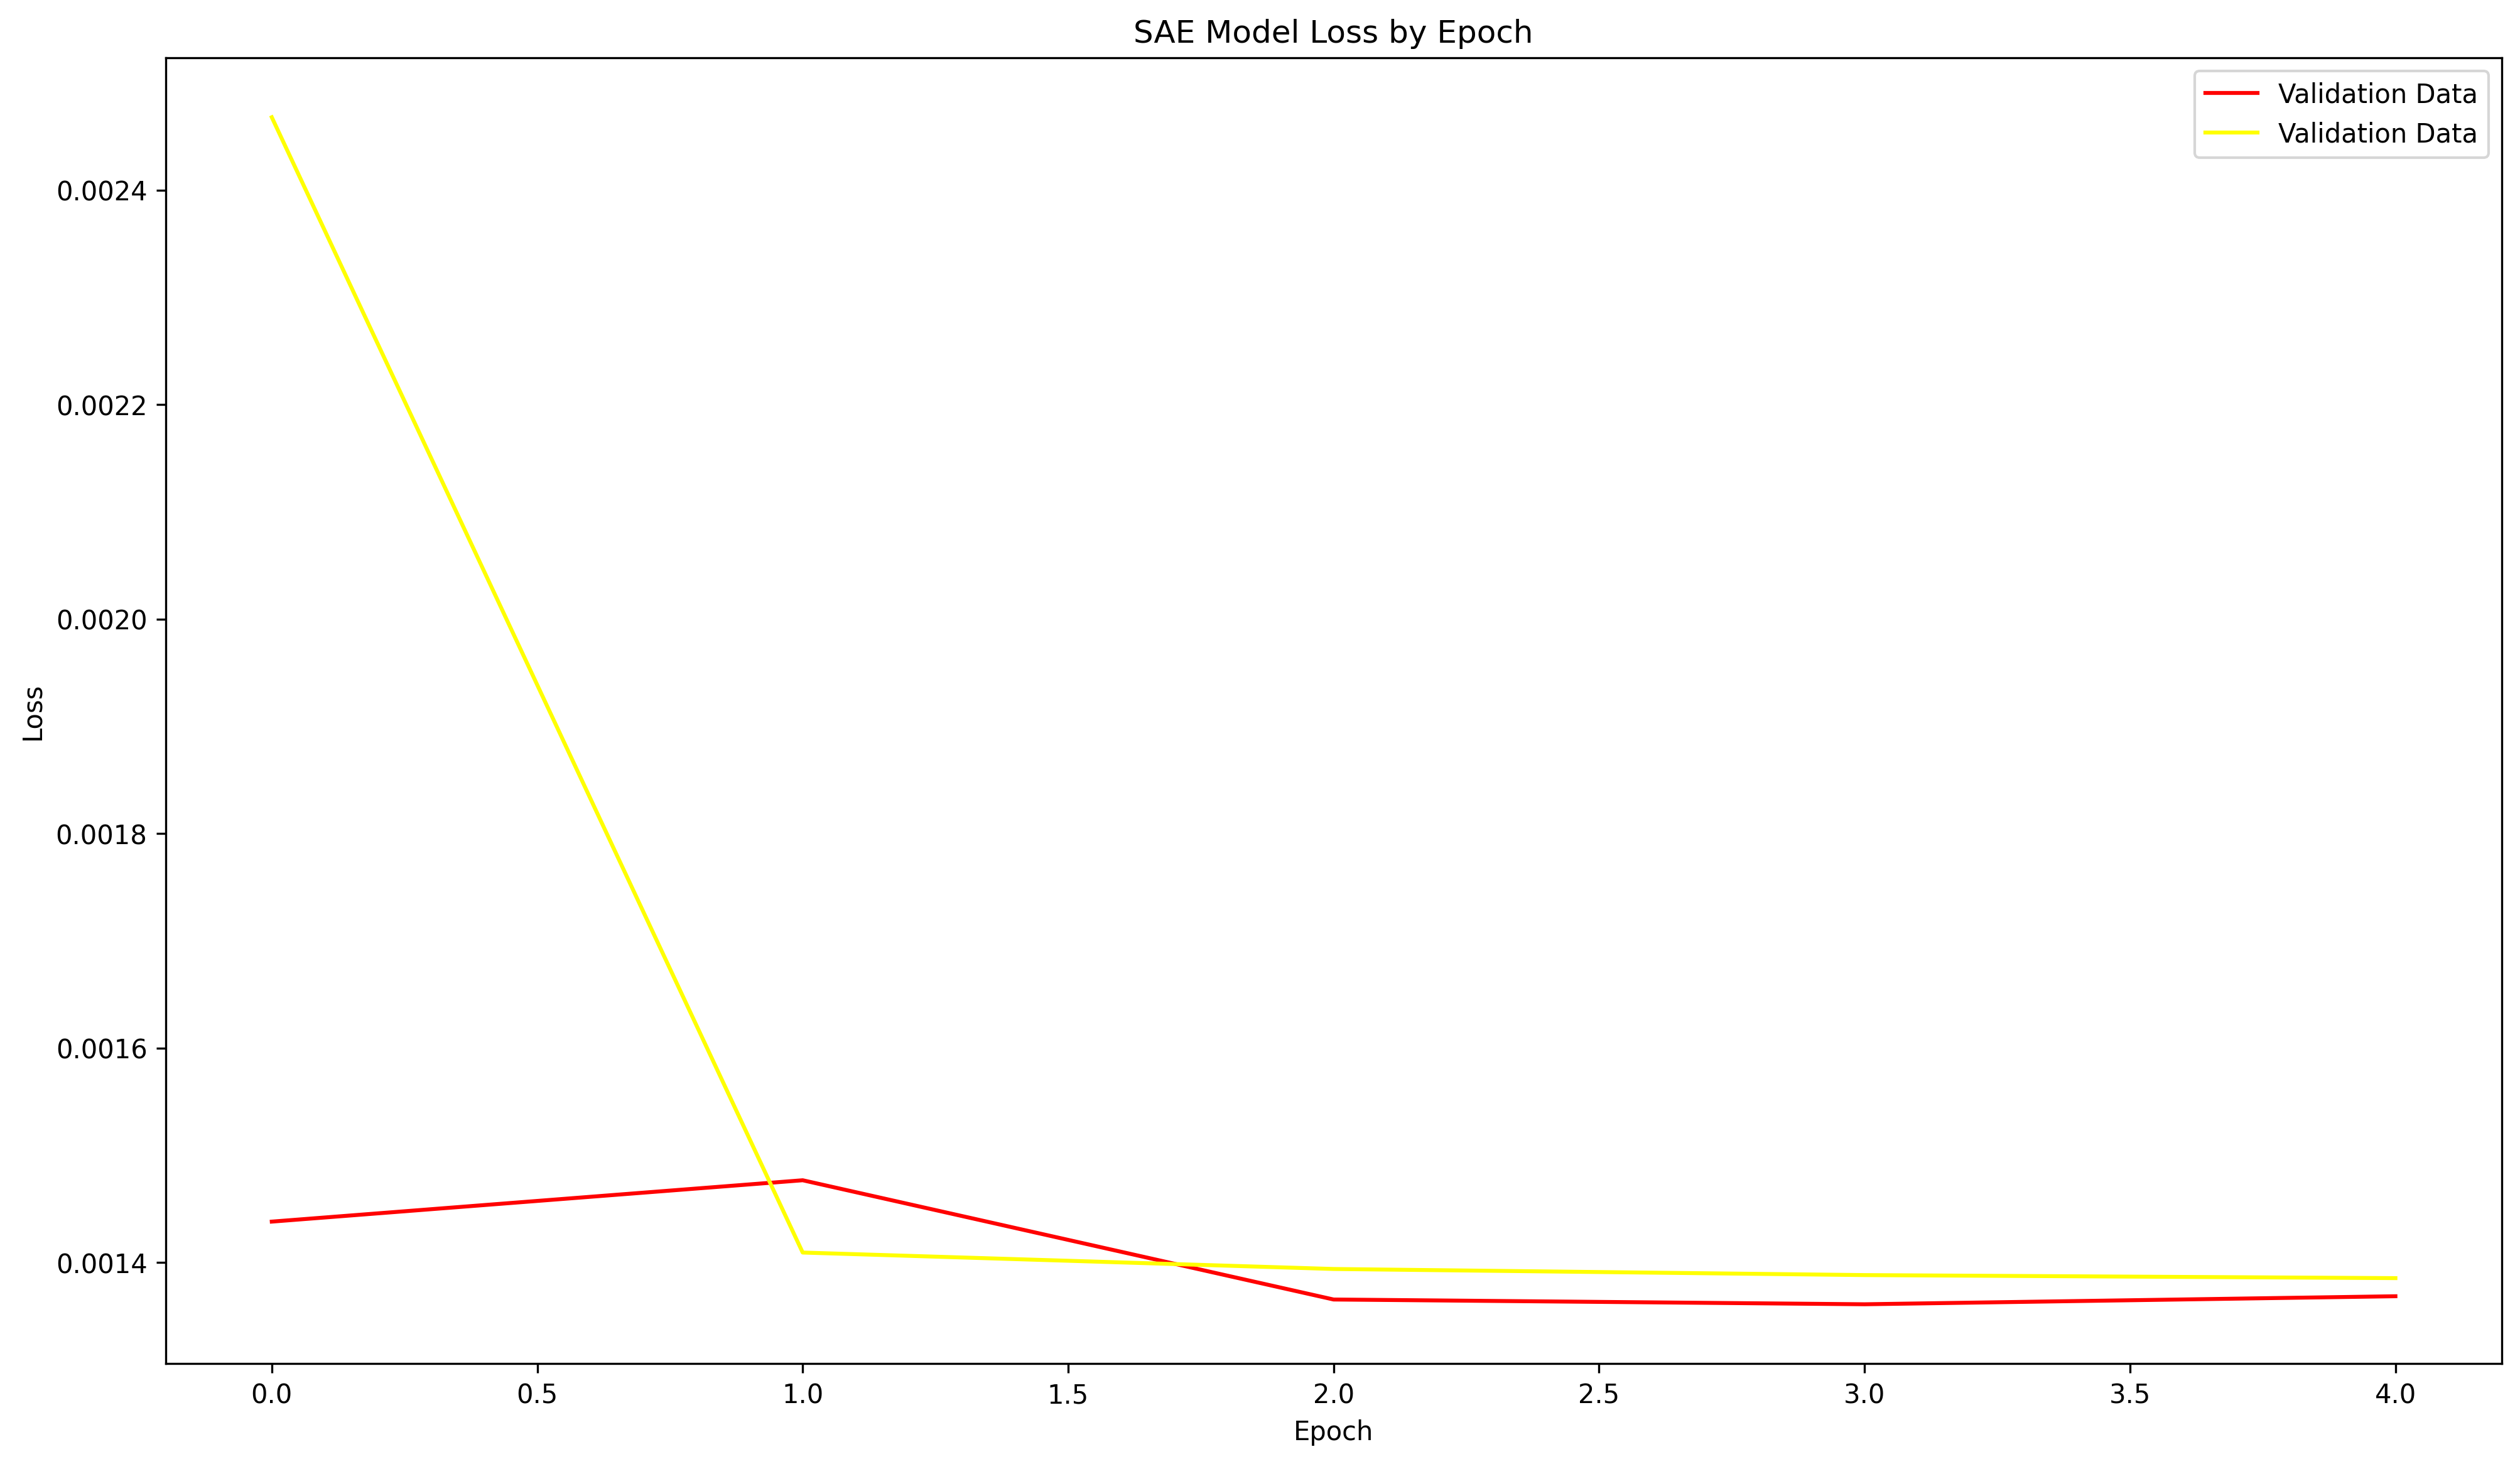

In [ ]:
Sfig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='SAE Model Loss by Epoch', loc='center')
ax.plot(history['val_loss'], label='Validation Data', color='red')
ax.plot(history['loss'], label='Validation Data', color='yellow')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.legend()
plt.show()

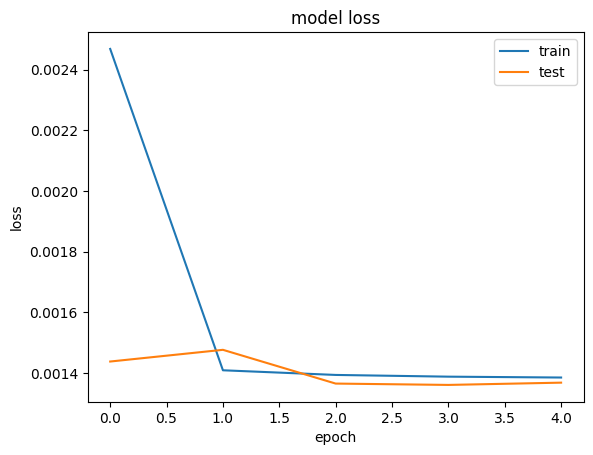

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [ ]:
SAE_model.get_weights()

[array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
          3.05549085e-01, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00,  2.00856954e-01, -0.00000000e+00,
         -0.00000000e+00,  2.08232086e-05, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00,  3.48160975

In [ ]:
# PLot Memory Space Graphs
